In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os 
import librosa
import librosa.display
import time

In [3]:
BATCH_SIZE = 100
ITERATIONS = 500
ITERATIONS_TEST = 10
EVAL_EVERY = 5
HEIGHT = 20
WIDTH = 130
NUM_LABELS = 0
LABEL_TO_INDEX_MAP = {}

In [4]:
os.chdir("D:")
os.listdir(os.getcwd())
testing_path = os.path.join(os.getcwd(),'IRMAS-TestingData-Part1')
training_path = os.path.join(os.getcwd(), 'IRMAS-TrainingData')


In [5]:
labels = os.listdir(training_path)
index = 0
for label in labels:
    LABEL_TO_INDEX_MAP[label] = index
    index += 1
    NUM_LABELS = len(LABEL_TO_INDEX_MAP)

print(LABEL_TO_INDEX_MAP)

{'cel': 0, 'cla': 1, 'flu': 2, 'gac': 3, 'gel': 4, 'org': 5, 'pia': 6, 'sax': 7, 'tru': 8, 'vio': 9, 'voi': 10}


In [6]:
# Converting to MEL frequency, Scaling

def mfcc_get(path_files):
    wave, sr = librosa.load(path_files, mono=True)
    mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc = HEIGHT)
    return mfccs


In [7]:
X = []
y = []

for i in labels:
    training_folders = os.path.join(training_path, i)
    for a in os.listdir(training_folders):
        training_audio = os.path.join(training_folders, a)
        X.append(mfcc_get(training_audio))
        encoding = [0] * len(LABEL_TO_INDEX_MAP)
        encoding[LABEL_TO_INDEX_MAP[i]] = 1
        y.append(encoding)


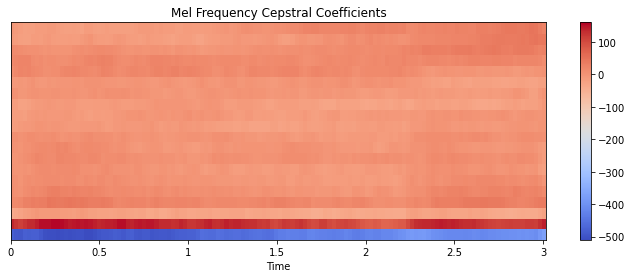

In [8]:

plt.figure(figsize=(12,4))
plt.title("Mel Frequency Cepstral Coefficients")
librosa.display.specshow(np.array(X)[1], x_axis ="time")
plt.colorbar()

In [185]:
X_test= []
y_test=[]

testing_path = 'D:\\IRMAS-TestingData-Part1\\Part1\\'
for i in os.listdir(testing_path):
    if ".txt" in i:    
        file = open(os.path.join(testing_path, i), "r")
        f = file.readlines()
        labels = list(map(str.strip, f))
        string_labels = ''.join(labels)
        encoding2 = [0] * len(LABEL_TO_INDEX_MAP)
        encoding2[LABEL_TO_INDEX_MAP[string_labels]] = 1
        y_test.append(encoding2)
        
    else:
        testing_audio = os.path.join(testing_path, i)
        wave, sr = librosa.load(testing_audio, mono=True)
        mfccs_test = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc = 150)
        mfccs_test = np.pad(mfccs_test, ((0,0), (0,   975 - len(mfccs_test[0]) )), mode="constant")
        X_test.append(mfccs_test)


(300, 20, 130)
(300,)


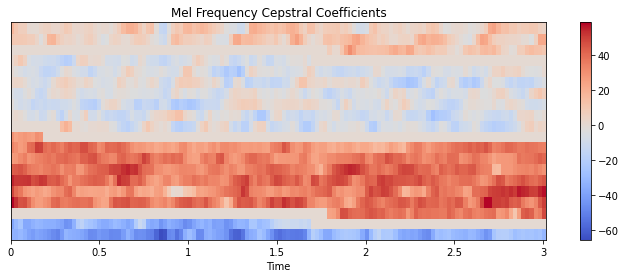

In [187]:
test_data = np.array(X_test)
test_data.resize(test_data.shape[0], 20, 130)
test_labels = tf.argmax(np.array(y_test), axis=1)

print(test_data.shape)
print(test_labels.shape)
plt.figure(figsize=(12,4))
plt.title("Mel Frequency Cepstral Coefficients")
librosa.display.specshow(test_data[1], x_axis ="time")
plt.colorbar()

In [234]:
# Creating a model

train_data = np.array(X)
train_labels = np.array(y)
train_data = np.random.random(size=(6705, 20, 130))
train_data = np.expand_dims(train_data, axis=3)
train_labels = tf.argmax(train_labels, axis=1)
print(train_data.shape, train_labels.shape)

model = Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=train_data.shape[1:]))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(34, activation="relu"))
model.add(layers.Dense(NUM_LABELS))

model.summary()

(6705, 20, 130, 1) (6705,)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 18, 128, 32)       320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 9, 64, 32)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 62, 32)         9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 31, 32)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2976)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               381056    
_________________________________________________________________
dense_19 (Dense)           

In [235]:
                                  # Shuffling data
# Training
np.random.shuffle(train_data)
shuffled_train_labels = tf.random.shuffle(train_labels)
# Testing
np.random.shuffle(test_data)
shuffled_test_labels = tf.random.shuffle(test_labels)
test_data_ed = np.expand_dims(test_data, axis=3)

In [236]:
                                # Compiling the model

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [237]:
# Training the data

history = model.fit(train_data , shuffled_train_labels, epochs=30, validation_data=(test_data_ed, shuffled_test_labels))

Train on 6705 samples, validate on 300 samples
Epoch 1/30
6705/6705 [==============================] - 1s 178us/sample - loss: 2.3847 - accuracy: 0.1141 - val_loss: 2.2089 - val_accuracy: 0.2100
Epoch 2/30
6705/6705 [==============================] - 1s 117us/sample - loss: 2.3807 - accuracy: 0.1111 - val_loss: 2.1983 - val_accuracy: 0.1967
Epoch 3/30
6705/6705 [==============================] - 1s 112us/sample - loss: 2.3811 - accuracy: 0.1130 - val_loss: 2.2512 - val_accuracy: 0.1767
Epoch 4/30
6705/6705 [==============================] - 1s 110us/sample - loss: 2.3797 - accuracy: 0.1122 - val_loss: 2.2682 - val_accuracy: 0.2000
Epoch 5/30
6705/6705 [==============================] - 1s 111us/sample - loss: 2.3799 - accuracy: 0.1160 - val_loss: 2.5724 - val_accuracy: 0.2300
Epoch 6/30
6705/6705 [==============================] - 1s 111us/sample - loss: 2.3787 - accuracy: 0.1135 - val_loss: 2.2289 - val_accuracy: 0.2000
Epoch 7/30
6705/6705 [==============================] - 1s 111us/